Imports

In [2]:
! pip install scikit-learn==1.1.3

  Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (32.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.1.post1
    Uninstalling scikit-learn-1.4.1.post1:
      Successfully uninstalled scikit-learn-1.4.1.post1


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

In [30]:
import matplotlib.pyplot as plt

In [2]:
from bedmap import ClassifyBedforms

## Bring in the ground truth and estimated bedforms

Estimate the bedforms using the RF model.

In [3]:
bedforms = ClassifyBedforms('data/BedformData.csv')

In [4]:
estimated_bedforms = bedforms.predicted_bedform

In [6]:
data = pd.read_csv('data/BedformData.csv')

In [7]:
data.columns

Index(['Topo', 'Bed', 'Area', 'Elong', 'Y/N'], dtype='object')

In [13]:
measured_bedforms = np.array(data['Y/N'])

In [14]:
type(measured_bedforms)

numpy.ndarray

In [15]:
type(estimated_bedforms)

numpy.ndarray

## Measure performance metrics

Performance metric are established, quantitative measures used to assess the effectiveness or quality of model predictions in machine learning tasks. We'll be using metrics available in the `sklearn` library.

We'll start with the most straightforward measure, called "accuracy," which measures the ratio of correctly classified instances over all instances. The equation is (Number of True Positives + Number of True Negatives)/(Number of all Predictions).

In [20]:
accuracy = accuracy_score(measured_bedforms, estimated_bedforms)
print("Accuracy:", accuracy)

Accuracy: 0.9753907503636078


"Precision" is also a commonly used metric, and measures the ratio of true positives to all predicted positives. The equation is (Number of True Positives)/(Number of True Positives + Number of False Positives).

In [21]:
precision = precision_score(measured_bedforms, estimated_bedforms)
print("Precision:", precision)

Precision: 0.7055070517125588


"Recall" measures the ratio of actual positives that are correctly identified by the classifier while accounting for positives missed by the classifier. It's calculated as (Number of True Positives)/(Number of True Positives + Number of False Negatives). Recall can be used to optimize in CV when the cost of false negatives is high, i.e. when a model has a tendency to underpredict, which the current state of our model does.

In [22]:
recall = recall_score(measured_bedforms, estimated_bedforms)
print("Recall:", recall)

Recall: 0.13433503836317134


The "F1 score" is the harmonic mean between precision and recall. This means that an F1 score provides a balanced measure between precision and recall tipped towards the lower score, making it a useful metric for evaluating classifiers in situations where you want to consider both false positives and false negatives equally.

In [23]:
f1 = f1_score(measured_bedforms, estimated_bedforms)
print("F1 Score:", f1)

F1 Score: 0.22569556343323663


The "ROC AUC Score" (Receiver Operating Characteristic Area Under Curve Score) is a more complex score (read more here: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5), that is useful in evaluating how well a binary classifier can distinguish between the two classes by examining its trade-off between true positive rate and false positive rate across different threshold settings.

In [25]:
roc_auc = roc_auc_score(measured_bedforms, estimated_bedforms)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.5663984314231476


The "PR AUC Score" (Precision/Recall Area Under Curve Score) In summary, the PR-AUC score evaluates how well a binary classifier can trade off precision and recall. It is particularly useful when the classes are highly imbalanced (as they are for us), because it provides insights into the model's ability to correctly identify positive instances while minimizing false positives.

In [27]:
pr_auc = average_precision_score(measured_bedforms, estimated_bedforms)
print("PR AUC Score:", pr_auc)

PR AUC Score: 0.11788645828536844


Finally, the assessment that you might have seen in other papers, the "confusion matrix." The confusion matrix is nice because it allows for easy visualization of the model performance. In our case of binary classficiation, it is a 2x2 matrix showing number of true positives, number of false positives, number of true negatives, and number of false negatives. It can also be measured using `sklearn`.

In [29]:
conf_matrix = confusion_matrix(measured_bedforms, estimated_bedforms)

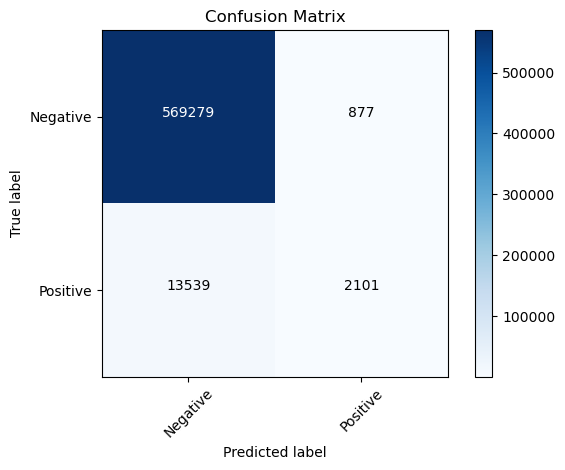

In [31]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

This shows that we're really good at predicting when something isn't a bedform, but we aren't that great at predicting when something *is* a bedform. This is definitely something that we want to improve on, and we can increase this improvement through CV. We'll re-run our cross validation, and instead of relying on accuracy, which is weighted by how many true negatives we are measuring, we'll weight on F1 score and see how this improves our model fit.